In [1]:
import numpy as np
from funcy import flatten
import copy

import jointpmf as jp

# import networkx as netx  # IMPORTANT: if you import networkx then don't use `nx`! ALready used as variable name below.

import itertools

import importlib
import traceback
import matplotlib.pyplot as plt

import pandas as pd
from scipy.optimize import minimize

from typing import Iterable, Sequence

c:\Users\rquax1\Repositories\jointpmf_package\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Independent input variables and 1 SRV output

## Construct the input variables' marginal distributions and the SRV conditional distribution

In [2]:
ps = [[0.5, 0.3, 0.2], [0.4, 0.35, 0.25]]  # marginal probabilities of the input variables

ps = list(map(lambda arr: sorted(arr, reverse=True), ps))  # dimensions: (variable index, variable value)
ps = [np.array(psi, dtype=float) for psi in ps]
kxs = tuple(map(len, ps))  # number of states per input variable (length is number of input variables) to the SRV
nx = len(kxs)  # number of input variables

if __debug__:  # make sure all marginal probability mass functions sum to 1.0
    for pxis in ps:
        np.testing.assert_almost_equal(sum(pxis), 1.0)

ns = 1  # where possible and relatively easy I will generalize code for ns >= 1 but if needed I will hardocde ns == 1 (with assertion)
ks = min(kxs)  # number of states for the SRV that is to be found

srv_ps_shape = kxs + (ks,)  # for convenience, used in multiple places below

In [3]:
# this generates a random P(S|X). `srv_ps[x1]...[xn]` is an array of size `ns` and are probabilities
srv_ps = np.random.random(srv_ps_shape)
srv_ps /= srv_ps.sum(axis=-1, keepdims=True)  # normalize each Pr(S | X=x)

In [5]:
### HELPER functions for the input variables

def joint_probability_multiple_inputs(xixs: Sequence[int], xvals: Sequence[int], ps: Sequence[np.ndarray] = ps) -> float:
    """Compute the product of marginal input value probabilities (thus assuming independence of inputs).

    Args:
        xixs (Sequence[int]): list of variable indices
        xvals (Sequence[int]): _description_
        ps (np.ndarray, optional): _description_. Defaults to ps.

    Returns:
        float: _description_
    """
    assert len(xixs) == len(xvals)
    assert len(set(xixs)) == len(xixs), 'should not doubly multiply with the same variable\'s probability.'

    # return ps[tuple(zip(xixs, xvals))].prod()
    # return ps[xixs, xvals].prod()
    return np.prod([ps[xix][xv] for xix, xv in zip(xixs, xvals)])


def joint_probability_all_inputs(xvals: Sequence[int], ps: Sequence[np.ndarray] = ps) -> float:
    """Compute the product of all marginal input value probabilities (thus assuming independence of inputs).

    Args:
        xvals (Sequence[int]): a value for each input variable (zero-indexed)
        ps (np.ndarray, optional): _description_. Defaults to ps.

    Returns:
        float: joint probability of the given joint state
    """
    # assert len(xvals) == nx, f'{xvals=}, {nx=}'
    # assert len(srv_ps.shape) == nx + ns
    # assert len(ps) == nx
    if __debug__:
        local_kxs = list(map(len, ps))
        assert np.all(np.less(xvals, local_kxs)), 'each value in `xvals` should be in the range 0,..,kx-1 where `kx` is the number of possible values for that input variable.'
        assert len(xvals) == len(ps), f'{len(xvals)=} is not equal to {len(ps)=}'

    # return ps[tuple(zip(range(nx), xvals))].prod()
    # return ps[range(nx), xvals].prod()
    return np.prod([ps[xix][xv] for xix, xv in enumerate(xvals)])

In [6]:
# test if all joint input probabilities sum to unity
np.testing.assert_almost_equal(1.0, sum([joint_probability_all_inputs(xvals, ps) 
                                         for xvals in itertools.product(*map(range, kxs))]))

In [7]:
### HELPER functions for the SRV variable

def marginalize_single_input(xix: int, srv_ps=srv_ps) -> np.ndarray:
    """Integrate out one input variable from the conditional SRV PMF. (Not in-place.)

    Args:
        xix (int): index of the input variable. Should be less then `len(np.shape(srv_ps))-1`.

    Returns:
        np.ndarray: conditional SRV PMF with one dimension less (one axis integrated out)
    """
    assert xix < len(np.shape(srv_ps))-1, 'at index len(np.shape(srv_ps))-1 is the SRV variables\' probabilities'

    local_kxs = list(map(len, ps))

    # note: there may be a more efficient, numpy-native way of doing this, but I could not find it quickly
    return sum([ps[xix][xval] * condition_single_input(xix, xval, srv_ps=srv_ps)
                for xval in range(local_kxs[xix])])


def condition_single_input(xix: int, xval: int, srv_ps=srv_ps) -> np.ndarray:
    """Take out one input variable from the conditional SRV PMF by selecting a value for it.

    Args:
        xix (int): index of the input variable. Should be less then `len(np.shape(srv_ps))-1`.
        xval (int): value for the input variable.
        srv_ps (np.ndarray, optional): conditional PMF of the SRV encoded as numpy array. Defaults to srv_ps.

    Returns:
        np.ndarray: conditional SRV PMF with one dimension less, basically P(S|X[xix]=xval)
    """
    assert xix < len(np.shape(srv_ps))-1, 'at index len(np.shape(srv_ps))-1 is the SRV variables\' probabilities'

    return srv_ps.take(xval, axis=xix)


def condition_multiple_inputs(xixs: Sequence[int], xvals: Sequence[int], srv_ps: np.ndarray = srv_ps) -> np.ndarray:
    """Take out multiple input variables from the conditional SRV PMF by selecting values for them.

    Essentially this function makes a series of calls to `specify_single_input`.

    Args:
        xixs (Sequence[int]): _description_
        xvals (Sequence[int]): _description_
        srv_ps (np.ndarray, optional): conditional PMF of the SRV encoded as numpy array. Defaults to srv_ps.

    Returns:
        np.ndarray: conditional SRV PMF with fewer dimensions, basically P(S|X[xixs]=xvals)
    """
    assert len(xixs) == len(xvals)
    assert len(set(xixs)) == len(xixs)

    # sort xixs in descending order while letting the corresponding xvals values move along accordingly
    xix_xval_pairs = list(zip(xixs, xvals))
    xix_xval_pairs = sorted(xix_xval_pairs, key=lambda pair: pair[0], reverse=True)

    srv_ps_res = srv_ps

    for xix, xval in xix_xval_pairs:
        srv_ps_res = condition_single_input(xix, xval, srv_ps_res)

    # commented out because it passed for a while, seems not needed:
    # if __debug__:
    #     if len(xixs) > 0:
    #         assert len(srv_ps_res.shape) < len(srv_ps.shape)
    #         assert len(srv_ps_res.shape) == len(srv_ps.shape) - len(xixs)
    
    return srv_ps_res


def condition_all_inputs(xvals: Sequence[int], srv_ps: np.ndarray = srv_ps) -> np.ndarray:
    """Take out all input variables from the conditional SRV PMF by selecting values for them.

    Essentially this function makes a series of `nx` calls to `specify_single_input`. This is 
    a slightly more efficient implementation than using `condition_multiple_inputs` (but barely I suspect).

    Args:
        xvals (Sequence[int]): one value per input variable, assumed sorted (starting with variable 0)
        srv_ps (np.ndarray, optional): conditional PMF of the SRV encoded as numpy array. Defaults to srv_ps.

    Returns:
        np.ndarray: conditional SRV PMF, P(S|X[xixs]=xvals) where `xixs` is `range(nx)`.
    """
    # assert len(xvals) == nx
    # assert len(srv_ps.shape) == nx + ns
    assert len(xvals) == len(np.shape(srv_ps)) - 1

    # sort xixs in descending order while letting the corresponding xvals values move along accordingly
    xix_xval_pairs = list(zip(range(nx), xvals))
    xix_xval_pairs = reversed(xix_xval_pairs)

    srv_ps_res = srv_ps

    for xix, xval in xix_xval_pairs:
        srv_ps_res = condition_single_input(xix, xval, srv_ps_res)

    # commented out because it passed for a while, seems not needed:
    # if __debug__:
    #     if len(xixs) > 0:
    #         assert len(srv_ps_res.shape) < len(srv_ps.shape)
    #         assert len(srv_ps_res.shape) == len(srv_ps.shape) - len(xixs)
    
    return srv_ps_res


def marginal_srv_ps(ps=ps, srv_ps=srv_ps) -> np.ndarray:
    return sum([joint_probability_all_inputs(xvals, ps) * condition_all_inputs(xvals, srv_ps)
                for xvals in itertools.product(*map(range, map(len, ps)))])
    # return srv_ps.sum(axis=range(len(srv_ps.shape)))

In [8]:
# should on average be roughly equal to [1/nx, ..., 1/nx], so close to uniform distribution, 
# if the SRV is generated randomly. If `ks` and `kx` are small then deviations can be large though.
marginal_srv_ps()

array([0.37169491, 0.29556426, 0.33274083])

In [9]:
def test_specify_multiple_inputs() -> None:
    """Meant to be used e.g. with `pytest` eventually."""
    orig_shape_srv_ps = srv_ps.shape

    assert np.all(condition_multiple_inputs([1], [1]) == condition_single_input(1, 1))

    s = condition_single_input(1, 1)
    assert np.all(condition_multiple_inputs([0,1], [1,1]) == condition_single_input(0, 1, srv_ps=s))

    assert np.all(np.equal(orig_shape_srv_ps, srv_ps.shape)), 'srv_ps is passed by reference (pointer), it got changed while it should not have'

test_specify_multiple_inputs()  # if no assertion or exception raised then it is successful

In [10]:
### HELPER functions for information-theoretic measures

def H(p_arr: Sequence[float]) -> float:
    """Generic entropy function"""
    if __debug__:
        np.testing.assert_almost_equal(np.sum(p_arr), 1.0, 5, "`p_arr` should sum to unity since it is a prob. distribution")

    with np.errstate(divide='ignore'):
        logps = np.log2(np.array(p_arr, dtype=float))
    return -sum(p_arr * np.where(np.isneginf(logps), 0.0, logps))


def entropy_srv(srv_ps: np.ndarray = srv_ps, ps: np.ndarray = ps, _precomp_marginal_probs=None) -> float:
    if _precomp_marginal_probs is None:
        _precomp_marginal_probs = marginal_srv_ps(ps=ps, srv_ps=srv_ps)
    else:
        if ns == 1:
            assert len(_precomp_marginal_probs) == ks
        else:  # untested
            assert np.all(np.equal(np.shape(_precomp_marginal_probs), ks))
        
    return H(_precomp_marginal_probs)


def entropy_input(xix: int, ps=ps) -> float:
    return H(ps[xix])


def entropy_inputs(ps=ps) -> float:
    return np.apply_along_axis(H, -1, ps)


def conditional_entropy_srv_all_inputs(srv_ps: np.ndarray = srv_ps, ps: np.ndarray = ps) -> float:
    """Average conditional entropy of the SRV given all its inputs."""
    return sum([joint_probability_all_inputs(xvals, ps=ps) * H(condition_all_inputs(xvals, srv_ps=srv_ps))
                for xvals in itertools.product(*map(range, kxs))])


def mutual_information_srv_all_inputs(srv_ps: np.ndarray = srv_ps, ps: np.ndarray = ps, _precomp_marginal_srv_probs=None) -> float:
    """Mutual information between the SRV and all the inputs, i.e., I(S:X) where X=[X_1,...,X_nx]."""
    totH = entropy_srv(srv_ps=srv_ps, ps=ps, _precomp_marginal_probs=_precomp_marginal_srv_probs)
    condH = conditional_entropy_srv_all_inputs(srv_ps=srv_ps, ps=ps)

    assert totH >= -1e7, 'entropy should be non-negative'
    assert condH >= -1e7, 'average conditional entropy should be non-negative'
    assert totH >= condH, 'H(X) should be larger or equal to H(X|Y) for any Y'

    return totH - condH
    

In [11]:
print(entropy_srv(), f' (should be close to {np.log2(ks):.2f} for randomly a generated SRV)')
print(conditional_entropy_srv_all_inputs())
print(mutual_information_srv_all_inputs(), ' (should be close to zero for a randomly generated SRV)')

1.57868200335726  (should be close to 1.58 for randomly a generated SRV)
1.263586144864554
0.31509585849270594  (should be close to zero for a randomly generated SRV)


## Naive interior point optimization

In [12]:
### HELPER functions for constraint-based optimization (naive)

def constraint_srv(srv_ps: np.ndarray = srv_ps, ps: np.ndarray = ps) -> float:
    """Returns a value that grows with the extent that the single-input cond. SRV distributions are not equal.

    This function is meant to be used with the SLSQP optimization (or similar) algorithm of scipy.optimize. A return
    value of 0 means that the given conditional distribution `srv_ps` is actually an SRV, in the sense that it has
    zero information about any individual input. The higher the return value, the larger the violation.

    Args:
        srv_ps (np.ndarray, optional): an array with shape kx + ks, where the last axis encodes the conditional probabilities
         of the SRV given values for all its `len(kx)` inputs. So, encoding P(S|X). Defaults to srv_ps.
        ps (np.ndarray, optional): a twodimensional array encoding [P(X1), P(X2), ...]. Implies is that the joint input
         variable distribution factorizes, so P(X) = P(X1) * P(X2) * ... Defaults to ps.

    Returns:
        float: degree of violation of the equality constraint of P(S|Xi=j) being equal for all i,j.
    """
    assert np.all(np.equal(srv_ps.shape, srv_ps_shape)), f'`srv_ps` should be conditional probabilities (is it in unit cube coordinates?) {srv_ps.shape=}'
    precomp_marginal_srv_ps = marginal_srv_ps(srv_ps=srv_ps, ps=ps)
    return np.log(sum([np.linalg.norm(condition_all_inputs(xvals, srv_ps=srv_ps) - precomp_marginal_srv_ps) 
                       for xvals in itertools.product(*map(range, kxs))]))

In [13]:
### HELPER functions for converting the SRV PMF to a unit cube formulation and back

def single_ps_to_unit_cube_coord(p_arr: np.ndarray) -> np.ndarray:
    ret = np.zeros(len(p_arr) - 1)  # pre-alloc
    
    remaining_prob_mass = 1.0
    for ix, p in enumerate(p_arr[:-1]):
        ret[ix] = p / remaining_prob_mass
        remaining_prob_mass -= p
    
    np.testing.assert_almost_equal(remaining_prob_mass, p_arr[-1], 5)

    return ret


def single_unit_cube_coord_to_ps(coord: np.ndarray) -> np.ndarray:
    ret = np.zeros(len(coord) + 1)  # pre-alloc

    remaining_prob_mass = 1.0
    for ix, c in enumerate(coord):
        ret[ix] = remaining_prob_mass * c
        remaining_prob_mass -= ret[ix]
    
    assert -1e5 < remaining_prob_mass <= 1.0

    ret[-1] = remaining_prob_mass

    return ret


def srv_ps_to_unit_cube(srv_ps: np.ndarray = srv_ps) -> np.ndarray:
    return np.apply_along_axis(single_ps_to_unit_cube_coord, axis=-1, arr=srv_ps)


def unit_cube_to_srv_ps(srv_coords: np.ndarray) -> np.ndarray:
    return np.apply_along_axis(single_unit_cube_coord_to_ps, axis=-1, arr=srv_coords)

# this is the shape of srv_ps_to_unit_cube(srv_ps), basically the last dimension gets one element less
cubed_srv_ps_shape = srv_ps_shape[:-1] + (srv_ps_shape[-1]-1,)

In [14]:
np.testing.assert_allclose(srv_ps, np.reshape(np.reshape(srv_ps, -1), srv_ps.shape))

In [15]:
np.testing.assert_allclose(single_ps_to_unit_cube_coord([0.60, 0.10, 0.30]), [0.6 , 0.25])
np.testing.assert_allclose(single_unit_cube_coord_to_ps(single_ps_to_unit_cube_coord([0.60, 0.10, 0.30])), [0.60, 0.10, 0.30])

In [16]:
np.testing.assert_allclose(srv_ps, unit_cube_to_srv_ps(srv_ps_to_unit_cube()))

### SLSQP

In [17]:
def constraint_srv_1d_cubed(cubed_srv_ps_1d: np.ndarray) -> float:
    """Helper function for scipy.optimize.minimize, because that can only handle 1D arrays, so I have to convert.
    
    This function assumes that a one-dimensional version of the 'cubed' SRV probabilities array is passed, like
    `srv_ps_to_unit_cube(srv_ps).reshape(-1)` would produce. It then converts back to the shape of `srv_ps` containing
    probabilities, and then calls `constraint_srv` to return its value.
    """
    return constraint_srv(unit_cube_to_srv_ps(np.reshape(cubed_srv_ps_1d, cubed_srv_ps_shape)))

In [18]:
_log_objective_fun_values = []

def objective_total_mi_1d_cubed(cubed_srv_ps_1d: np.ndarray, log=False) -> float:
    """Helper function for scipy.optimize.minimize, because that can only handle 1D arrays, so I have to convert.
    
    This function assumes that a one-dimensional version of the 'cubed' SRV probabilities array is passed, like
    `srv_ps_to_unit_cube(srv_ps).reshape(-1)` would produce. It then converts back to the shape of `srv_ps` containing
    probabilities, and then calls `mutual_information_srv_all_inputs` to return its negative value (for minimization).
    """
    fun = mutual_information_srv_all_inputs(unit_cube_to_srv_ps(np.reshape(cubed_srv_ps_1d, cubed_srv_ps_shape)))

    if log:
        _log_objective_fun_values.append(fun)

    return -fun

In [19]:
np.testing.assert_almost_equal(constraint_srv_1d_cubed(srv_ps_to_unit_cube(srv_ps).reshape(-1)), constraint_srv(srv_ps))

In [20]:
# ps = np.array([[1./kx]*kx for kx in kxs], dtype=float)  # change `ps` to make it as easy as possible for the optimization
# ps = [np.array([0.5, 0.3, 0.2]), 
#       np.array([0.4, 0.35, 0.25])]  # marginal probabilities of the input variables
ps = [np.array([0., 0., 1.0]), 
      np.array([0., 0., 1.0])]  # marginal probabilities of the input variables

# TODO: not the correct `ps` is being used here somewhere

x0 = srv_ps_to_unit_cube(srv_ps).reshape(-1)
bounds = [(0, 1)]*len(x0)

np.testing.assert_allclose(unit_cube_to_srv_ps(np.reshape(x0, cubed_srv_ps_shape)), srv_ps)

constraints = [{'type': 'eq', 'fun': constraint_srv_1d_cubed}]

_log_objective_fun_values = []  # reset the log of objective function values

optres = minimize(objective_total_mi_1d_cubed, x0, method='SLSQP', bounds=bounds, constraints=constraints, 
                  args=(True,), options={'maxiter': 1000})

srv_ps_opt = unit_cube_to_srv_ps(np.reshape(optres.x, cubed_srv_ps_shape))

print(f'{optres.success=}')
print(f'{optres.message=}')
print(f'Optimal SRV found: {srv_ps_opt=}')
print(f'Constraint SRV (should be zero): {constraint_srv(srv_ps_opt)=}')
print(f'Objective function (should be as high as possible): {mutual_information_srv_all_inputs(srv_ps_opt)=}')
print(f'Upper bound of the objective function: {min(entropy_inputs())}')

optres.success=True
optres.message='Optimization terminated successfully'
Optimal SRV found: srv_ps_opt=array([[[4.71136723e-01, 0.00000000e+00, 5.28863277e-01],
        [3.65638165e-01, 3.08907291e-01, 3.25454543e-01],
        [1.96840984e-01, 8.03159016e-01, 7.77156117e-16]],

       [[3.65638501e-01, 3.08907195e-01, 3.25454304e-01],
        [3.65638277e-01, 3.08907267e-01, 3.25454456e-01],
        [3.65638129e-01, 3.08907399e-01, 3.25454472e-01]],

       [[3.65638038e-01, 3.08907296e-01, 3.25454666e-01],
        [3.65638158e-01, 3.08907375e-01, 3.25454467e-01],
        [3.65638255e-01, 3.08907445e-01, 3.25454301e-01]]])
Constraint SRV (should be zero): constraint_srv(srv_ps_opt)=7.993933430833475e-07
Objective function (should be as high as possible): mutual_information_srv_all_inputs(srv_ps_opt)=0.22496259235940075
Upper bound of the objective function: 1.4854752972273344


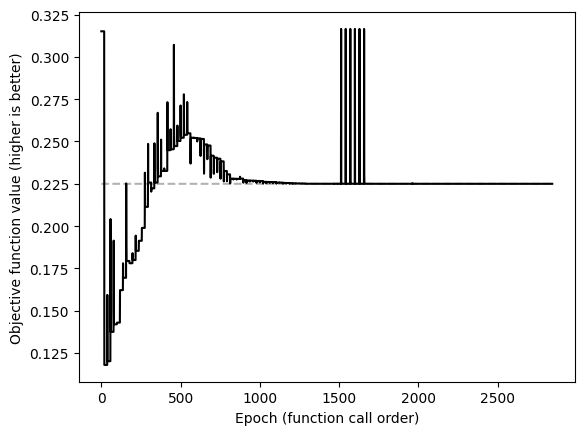

In [21]:
# NOTE: there can be excursions to (very) high values in this plot, but remember, this is only showing the
# objective function value, not the extent of constraint violation. In other words, the objective value might
# sometimes be large but the constraints violated strongly, such that the final outcome (dashed line) is lower than 
# some excursions.
plt.plot(_log_objective_fun_values, '-k')
plt.xlabel('Epoch (function call order)')
plt.ylabel('Objective function value (higher is better)')
final_obj_val = mutual_information_srv_all_inputs(srv_ps_opt)
plt.plot([final_obj_val]*len(_log_objective_fun_values), '--k', alpha=0.3)
plt.show()

When using the norm directly as constraint, then it seems that the SLSQP algorithm does not work at all on either the randomly generated case nor on the easiest case of independent uniform inputs. When using the logarithm of the constraint, it works better but still only around 0.27 of total MI whereas it should be around 1.5 for `kx=ks=3`. 

In [22]:
# TODO: implement the optimization also using an IPM approach

## Direct SRV approach

Here we try to implement a 'direct' method of defining an SRV, i.e., without optimization. It may not be a global optimum, but it would be guaranteed to be a non-trivial SRV (i.e., non-zero mutual information with both inputs together, but zero information with either input).

In [23]:
# for testing, let's use this heterogeneous set of input probabilities (sorted in descending order!)
# ps = [np.array([0.5, 0.3, 0.2]), 
#       np.array([0.4, 0.35, 0.25])]  # marginal probabilities of the input variables

ps = [np.array([0.55, 0.35, 0.1]), 
      np.array([0.4, 0.35, 0.25])]  # marginal probabilities of the input variables

# ps = [np.ones(kxs[xix]) / float(kxs[xix]) for xix in range(nx)]

ps

[array([0.55, 0.35, 0.1 ]), array([0.4 , 0.35, 0.25])]

In [24]:
def unit_vector(i: int, n: int, dtype=int):
    """Construct a 1D vector with a single 1-value in one place and 0-values in all other places."""
    vec = np.zeros(n, dtype=dtype)
    vec[i] = 1
    return vec

In [25]:
# these are the probability distributions of the SRV in the 'bottom' row, i.e., for the smallest marginal probability 
# of the first input variable. This is used because it always induces a proper conditional distribution
# NOTE: things like `kxs[1:]` appear in order to generalize hopefully (later) to more than 2 inputs.
last_row_srv_ps = np.array([unit_vector(i % ks, ks, dtype=float) for i in range(np.prod(kxs[1:]))], dtype=float)
last_row_srv_ps = np.reshape(last_row_srv_ps, kxs[1:] + (ks,))

print(f'{last_row_srv_ps=}')

# perform element-wise multiplication, so each row-vector of probabilities in `last_row_srv_ps` with 
# a single probability in `ps[-1]`. The result is the conditional distribution p(S|X[-1]=kxs[-1]-1), i.e., 
# the last input variable having the highest possible value (<-- lowest marginal probability). For an SRV,
# all conditional distributions p(S|X[i]=j) should be equal for all i and j, which implies that this is also 
# the marginal distribution p(S) already.
p_S = np.sum(last_row_srv_ps * np.array(ps[1:]).T, axis=0)

print(f'{p_S=}')

last_row_srv_ps=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
p_S=array([0.4 , 0.35, 0.25])


In [26]:
# as an example, this complicated itertools expression is basically equal to a nested for-loop, like
# [[... for j in kxs[1]] for i in kxs[0]], but then generalized to any length of `kxs`, so any number of inputs.
# Then, it reverses the order because we want to start 'walking' back from the least probable input state to the next
# least probable input state, etc.
# this is going to be used as a list of values for multiple inputs (but here is just an example)
list(itertools.product(*map(lambda x: reversed(range(x)), (3, 3))))

[(2, 2), (2, 1), (2, 0), (1, 2), (1, 1), (1, 0), (0, 2), (0, 1), (0, 0)]

In [27]:
def conditional_srv_given_single_input(xix: int, xval: int, ps: Sequence, srv_ps: np.ndarray) -> np.ndarray:
    """Calculate p(S|X[xix]=xval).

    Args:
        xix (int): index of input variable to be conditioning for
        xval (int): value of the input variable
        ps (Sequence): a list of input distributions (PMFs)
        srv_ps (np.ndarray): a numpy array specifying a PMF for the SRV, indexed by input variable values 
         like `srv_ps[xval1]...[xvaln]` where `n==len(ps)`.

    Returns:
        np.ndarray: a PMF for the SRV, no longer conditioning on any input variables (variable `xix` is conditioned
         on and the rest is integrated out).
    """
    return marginal_srv_ps([ps[i] for i in range(len(ps)) if not i == xix], 
                           condition_single_input(xix, xval, srv_ps))


def conditional_entropy_srv_given_single_input_value(xix: int, xval: int, ps: Sequence, srv_ps: np.ndarray) -> np.ndarray:
    """Calculate H(S|X[xix]=xval).

    Args:
        xix (int): index of input variable to be conditioning for
        xval (int): value of the input variable
        ps (Sequence): a list of input distributions (PMFs)
        srv_ps (np.ndarray): a numpy array specifying a PMF for the SRV, indexed by input variable values 
         like `srv_ps[xval1]...[xvaln]` where `n==len(ps)`.

    Returns:
        np.ndarray: a PMF for the SRV, no longer conditioning on any input variables (variable `xix` is conditioned
         on and the rest is integrated out).
    """
    p_S_given_xix_equals_xval = conditional_srv_given_single_input(xix, xval, ps, srv_ps)

    return H(p_S_given_xix_equals_xval)


def mutual_information_srv_given_single_input(xix: int, ps: Sequence, srv_ps: np.ndarray) -> np.ndarray:
    H_S = entropy_srv(srv_ps=srv_ps, ps=ps)
    H_S_given_Xi = sum([ps[xix][xval] * conditional_entropy_srv_given_single_input_value(xix, xval, ps=ps, srv_ps=srv_ps) 
                        for xval in range(len(ps[xix]))])
    
    return H_S - H_S_given_Xi

In [28]:
np.take((1,2,3,4), [0,1,3])

array([1, 2, 4])

In [30]:
def input_variable_sorted_values(kix: int):
    return map(lambda tuple: tuple[0], sorted(zip(range(kxs[kix]), ps[kix]), key=lambda pair: pair[-1]))

In [31]:
srv_ps_direct = np.zeros(srv_ps_shape, dtype=float)  # initialize

# here I find the index of the input variable that has the smallest probability for any of its values. The goal of this is
# to be able to iterate over the row/column that is associated to this minimum probability (in the contingency table) so that
# it is guaranteed that the procedure below always results in a proper SRV.
min_prob_input_ix, min_prob = min(zip(range(len(kxs)), list(map(min, ps))), key=lambda pair: pair[-1])

# here I make sure I iterate over all input states (`xvals`) in such a way that the entire row/column associated to the 
# minimum probability is populated first. In general, the values of the input variables are here
# sorted in ascending order of probability, so that low-probability states are populated first (this seems to minimize the chance of errors).
for xval_min_loop_ix, xval_min_prob_input_var in enumerate(input_variable_sorted_values(min_prob_input_ix)):
    # note: this complicated itertools expression is basically equal to a nested for-loop, like
    # [[... for j in kxs[1]] for i in kxs[0]], but then generalized to any length of `kxs`, so any number of inputs.
    for xvals_rest in itertools.product(*[input_variable_sorted_values(kix) for kix, k in enumerate(kxs) if not kix == min_prob_input_ix]):
        xvals = xvals_rest[:min_prob_input_ix] + (xval_min_prob_input_var,) + xvals_rest[min_prob_input_ix:]

        if xval_min_loop_ix == 0:
            # print(f'debug: before starting loop (if) ({xvals=}): {srv_ps_direct=}')

            # this is the last row (or slice), where we want to insert some a priori choices for SRV conditional distributions, 
            # just because we are free to pick anything and we need to start somewhere. We use here what we
            # already computed before.
            srv_ps_direct[xvals] = last_row_srv_ps[xvals_rest]  # overwrite probability vector

            # print(f'debug: --> after starting loop (if) ({xvals=}): {srv_ps_direct=}')
        else:
            # print(f'debug: before starting loop (else) ({xvals=}): {srv_ps_direct=}')

            # see explanation at `max_possible_cond_prob_per_srv_val` below; this stores minimum of all maximum possible probs
            max_possible_srv_probs_overall = np.ones(np.shape(srv_ps_direct[xvals]))

            for xix, xval in enumerate(xvals):
                np.testing.assert_allclose(srv_ps_direct[xvals], np.zeros(np.shape(srv_ps_direct[xvals])), 
                                           err_msg=f'I did not set these SRV probabilities yet, so they should be still zero. {srv_ps_direct[xvals]=}')
                cond_srv = conditional_srv_given_single_input(xix, xval, ps, srv_ps_direct)
                np.testing.assert_array_less(cond_srv, p_S + 1e-5*np.ones(np.shape(p_S)), f'no p(S|X[i]=j) should be able to exceed p(S). {xix=}, {xval=},\n----\nsrv_ps_direct:\n----\n{srv_ps_direct}\n')
                allowance = p_S - cond_srv  # this is how much probability is still 'allowed' for each SRV value in the direction of X[xix]=xval.

                # if __debug__:
                #     if xix == 1 and xval == 2:  # finding bug
                #         print(f'error: {cond_srv=}')
                #         print(f'error: {allowance=}')

                # set to an invalid (1, ..., 1) conditional probability p(S|\vec{X}=xvals), just to be able to compute what are the maximum
                # p(S|X[xix]=xval) we could achieve
                srv_ps_direct[xvals] = np.ones(np.shape(srv_ps_direct[xvals]))
                # NOTE: `cond_srv_max` may well be larger than p_S in some places, which is of course not allowed,
                # but we just use this to compute which conditional probability for which value we can set for the SRV.
                cond_srv_max = conditional_srv_given_single_input(xix, xval, ps, srv_ps_direct)
                srv_ps_direct[xvals] = np.zeros(np.shape(srv_ps_direct[xvals]))  # revert

                # if __debug__:
                #     if xix == 1 and xval == 2:  # finding bug
                #         print(f'error: {cond_srv_max=}')

                # this is not meant as a PMF but does have the same shape as `srv_ps_direct[xvals]`; it stores
                # the maximum possible conditional probability p(S=i|X[xix]=xval), for each i
                max_possible_cond_prob_per_srv_val = (p_S - cond_srv) / (cond_srv_max - cond_srv)
                max_possible_cond_prob_per_srv_val = np.min([max_possible_cond_prob_per_srv_val, 
                                                             np.ones(np.shape(max_possible_cond_prob_per_srv_val), 
                                                                     dtype=float)], 
                                                            axis=0)
                assert np.min(max_possible_cond_prob_per_srv_val) >= 0.0, f'probabilities should not be negative: {max_possible_cond_prob_per_srv_val=}'

                # if __debug__:
                #     if xix == 1 and xval == 2:  # finding bug
                #         print(f'error: {(cond_srv_max - cond_srv) / (p_S - cond_srv)=}')
                #         print(f'error: {max_possible_cond_prob_per_srv_val=}')

                # now we have the maximum possible prob per SRV value, when considering this particular 'direction': for input
                # variable `xix` and its value `xval`. One could see this as a row or column in the (2 or more)-dimensional table
                # of SRV PMFs where each dimension is one of the input variable's possible values.
                max_possible_srv_probs_overall = np.min([max_possible_srv_probs_overall, max_possible_cond_prob_per_srv_val], axis=0)

            # create a list of tuples like [(SRV_states1, maxprob1), (SRV_states2, maxprob2), ....], sorted in descending order on
            # the maxprobs.
            max_possible_prob_tuples = zip(itertools.product(*map(lambda x: range(x), np.shape(max_possible_srv_probs_overall))), max_possible_srv_probs_overall)
            max_possible_prob_tuples = sorted(max_possible_prob_tuples, key=lambda tup: tup[-1], reverse=True)

            assigned_total_prob_mass = 0.0  # amount of probability mass already placed in `srv_ps_direct`
            for srv_vals, maxprob in max_possible_prob_tuples:
                assert 0.0 <= maxprob <= 1.0, f'maxprob should be a probability, but: {maxprob=}'
                assert assigned_total_prob_mass <= 1.0, 'todo: can be removed if it passes a few times'

                # prob_to_assign = min(1.0 - assigned_total_prob_mass, maxprob)
                if maxprob < 1.0 - assigned_total_prob_mass:
                    srv_ps_direct[xvals][srv_vals] = maxprob
                    assigned_total_prob_mass += maxprob

                    if __debug__:
                        cond_srv = conditional_srv_given_single_input(xix, xval, ps, srv_ps_direct)
                        np.testing.assert_array_less(cond_srv, p_S + 1e-5*np.ones(np.shape(p_S)), f'no p(S|X[i]=j) should be able to exceed p(S). {xix=}, {xval=},\n----\nsrv_ps_direct:\n----\n{srv_ps_direct}\n')
                else:
                    srv_ps_direct[xvals][srv_vals] = 1.0 - assigned_total_prob_mass
                    assigned_total_prob_mass = 1.0

                    if __debug__:
                        cond_srv = conditional_srv_given_single_input(xix, xval, ps, srv_ps_direct)
                        np.testing.assert_array_less(cond_srv, p_S + 1e-5*np.ones(np.shape(p_S)), f'no p(S|X[i]=j) should be able to exceed p(S). {xix=}, {xval=},\n----\nsrv_ps_direct:\n----\n{srv_ps_direct}\n')
                
                        np.testing.assert_almost_equal(assigned_total_prob_mass, 1.0, 
                                           err_msg=f'should have assigned a total probability mass of 1.0, but: {assigned_total_prob_mass=}')
                        np.testing.assert_almost_equal(np.sum(srv_ps_direct[xvals]), 1.0, 
                                           err_msg=f'should have assigned a total probability mass of 1.0, but: {assigned_total_prob_mass=}')

                    break  # we are done: assigned a total probability mass of 1.0

if np.min(np.sum(srv_ps_direct, axis=2)) < 1.0 - jp.jointpmf._prob_error_tol:
    print(f'FAIL: not all conditional SRV probabilities sum to exactly 1: minimum probs. sum: {np.min(np.sum(srv_ps_direct, axis=2))}')
else:
    print('SUCCESS')

SUCCESS


In [32]:
srv_ps_direct  # end result: a (hopefully) strongly correlated SRV

array([[[0.30681818, 0.47727273, 0.21590909],
        [0.72727273, 0.        , 0.27272727],
        [0.09090909, 0.63636364, 0.27272727]],

       [[0.375     , 0.25      , 0.375     ],
        [0.        , 0.71428571, 0.28571429],
        [1.        , 0.        , 0.        ]],

       [[1.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        ],
        [0.        , 0.        , 1.        ]]])

In [33]:
print(f'This is the mutual information of the direct SRV with all of its inputs, which is hopefully quite high: {mutual_information_srv_all_inputs(srv_ps_direct, ps)}.')
print(f'These are the single-input mutual informations, should be (very close to) zero: {[mutual_information_srv_given_single_input(xix, ps, srv_ps_direct) for xix in range(nx)]}.')

This is the mutual information of the direct SRV with all of its inputs, which is hopefully quite high: 0.5690882245424743.
These are the single-input mutual informations, should be (very close to) zero: [0.0, 0.0].


_Success!_

In [34]:
entropy_inputs(ps)

array([1.33666648, 1.55887185])

In [35]:
H([0.55,0.35,0.1])

1.3366664819166874